In [2]:
# Importing necessary libraries
import numpy as np
from matplotlib import pyplot as plt
import os
import torch
from ultralytics import YOLO
from tqdm import tqdm
import cv2, os, glob
import random
from numba import cuda
import yaml
import cv2 as cv
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from dataclasses import dataclass

In [ ]:
# Defining classes (car, truck, bus, person)
# The primary purpose here is to detect cars only.
classes_id = {
    'car': 0,
    'truck': 1, 
    'bus': 2,
    'person': 3
}
dir_images = r'/content/data_folder/images/'
dir_labels = r'content/data_folder/labels/'

assert os.path.isdir(dir_images), f"{dir_images} is not a valid directory"
assert os.path.isdir(dir_labels), f"{dir_labels} is not a valid directory"

img_files = [os.path.join(dir_images, img) for img in os.listdir(dir_images) if img.endswith(".jpg")]

# Sortig image files in a correct order
img_files = sorted(img_files, key=lambda img_path: int(os.path.splitext(img_path)[0].split("_")[-1]))

# Sortig xml files in a correct order
xml_files = [os.path.join(dir_labels, label) for label in os.listdir(dir_labels) if label.endswith(".xml")]
xml_files = sorted(xml_files, key=lambda xml_path: int(os.path.splitext(xml_path)[0].split("_")[-1]))

In [21]:
print(len(img_files))
print(len(xml_files))
assert len(img_files) == len(xml_files)

150
150


In [9]:
# Deriving the acutal shape of images
imgH, imgW = cv.imread(img_files[0], cv.IMREAD_UNCHANGED).shape[: 2]

# Reading images, and resizing them to a specific size
images = []
for img in img_files:
    img = cv.imread(img, cv.IMREAD_UNCHANGED)
    img = cv.resize(img, (224, 224), cv.INTER_AREA)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # converted to rgb format, therfor images can be read using plt.imshow
    images.append(img)

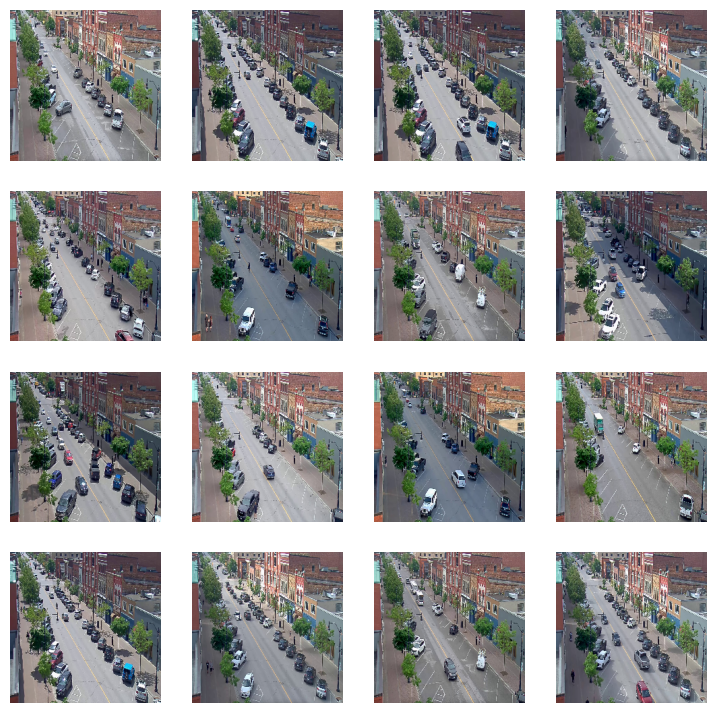

In [10]:
# Display a few samples
plt.figure(figsize=(9, 9))
n_rows = 4
n_cols = 4
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i +1)
    rand = random.randint(0, len(img_files) - 1)
    plt.imshow(images[rand])
    plt.axis("off")

In [127]:
imgH_compressed, imgW_compressed = images[0].shape[: 2]
for img in images:
    assert img.shape[: 2] == (imgH_compressed, imgW_compressed)

Yscale, Xscale = (imgH/ imgH_compressed, imgW/ imgW_compressed)
(Xscale, Yscale)

(8.571428571428571, 4.6875)

In [ ]:
labels_yolo_dir = r'/content/yolo_labels'

if not os.path.isdir(labels_yolo_dir) or not os.path.exists(labels_yolo_dir):
    os.mkdir(labels_yolo_dir)

# Parsing the xml file(labels):
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = (bbox[2] + bbox[0]) / (2 * w)
    y_center = (bbox[3] + bbox[1]) / (2 * h)
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h

    return [x_center, y_center, width, height]


def parse_labels(label):
    
    tree = ET.parse(label)
    root = tree.getroot()
    
    boxes = []
    result = []
    filename = root.find("filename").text
    rt, _ = os.path.splitext(filename)
    for obj in root.iter("object"):
        cls = obj.find("name").text
        
        if cls in classes_id:
            cls_id = classes_id.get(cls)
        
        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)/ Xscale
        ymin = int(bbox.find("ymin").text)/ Yscale
        xmax = int(bbox.find("xmax").text)/ Xscale
        ymax = int(bbox.find("ymax").text)/ Yscale
        boxes = [xmin, ymin, xmax, ymax]
        x_c, y_c, w, h = xml_to_yolo_bbox(boxes, imgH_compressed, imgW_compressed)
        
        # Converting data into a string
        bbox_string = f" {x_c} {y_c} {w} {h}"
        result.append(f"{cls_id} {bbox_string}")

    if result:
        with open(os.path.join(labels_yolo_dir, f"{rt}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))
    

In [ ]:
for xml in tqdm(xml_files):
    parse_labels(xml)

100%|██████████| 150/150 [00:00<00:00, 741.17it/s]


In [101]:
labels = glob.glob(os.path.join(labels_yolo_dir, "*.txt"))
for idx, label in enumerate(labels[: 3], start=0):
    with open(label, 'r') as f:
        print(f"____________text_file_{idx}____________\n\n", f.read(), '\n')

____________text_file_0____________

 0  0.7285714285714285 0.32135416666666666 0.14095238095238102 0.06770833333333329
0  0.6680952380952381 0.4893229166666667 0.21999999999999995 0.08697916666666668
0  0.6004761904761905 0.42890625 0.15523809523809526 0.07864583333333337
0  0.5542857142857143 0.3760416666666667 0.16190476190476183 0.06354166666666668
0  0.5490476190476191 0.3377604166666667 0.17047619047619053 0.05156249999999999
0  1.5833333333333333 0.49609375 0.15333333333333318 0.07968749999999998
0  1.4390476190476191 0.4421875 0.14857142857142872 0.06458333333333334
0  1.317142857142857 0.3997395833333333 0.13142857142857142 0.06718749999999998
0  1.2023809523809526 0.3606770833333333 0.10190476190476185 0.05364583333333333
0  0.5980952380952381 0.20338541666666668 0.07428571428571422 0.04322916666666665
0  0.6223809523809524 0.15156250000000002 0.06952380952380947 0.020833333333333322
0  0.7214285714285715 0.19348958333333335 0.0752380952380952 0.0234375
0  0.770952380952381 0

In [ ]:
# Splitting data into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.15, random_state=42, shuffle=True 
)
# Checking the shapes and data types of splitted data
X_train = np.array(X_train)
X_test = np.array(X_test)
print('X_train shape: {}, dtype: {}'.format(X_train.shape, X_train.dtype))
print('X_test shape: {}, dtype: {}'.format(X_test.shape, X_test.dtype))

X_train shape: (127, 224, 224, 3), dtype: uint8
X_test shape: (23, 224, 224, 3), dtype: uint8


In [22]:
# generating a data.yaml config file
def generate_yaml_file(path_yaml):
    
    classes = [val for val in classes_id.values()]
    
    # data directory        
    data = {
        'path': f'{os.path.join(os.getcwd(), 'data')}',
        'train': 'train/images',
        'val': 'validation/images',
        'nc': len(classes_id),
        'names': classes
    }
    # writing data to YAML file
    with open(path_yaml, 'w') as f:
        yaml.dump(data, f, sort_keys=False)
        
    return

path_yaml = os.path.join(os.getcwd(), "data.yaml")
generate_yaml_file(path_yaml)

In [3]:
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
# Creating a dataclass for trainConfig, specifying data augmentation attributes
@dataclass(frozen=True)
class trainConfig:
    EPOCHS: int = 250
    RESOLUTION: int = 640
    PATIENCE: int = 50
    BATCH: int = 4 # % GPU utilization
    SAVE: bool = True 
    # SEED: int = SEED_VALUE # Reproducibility Enabled
    # CLASSES: list[int] = [int(0)] # list of classes to perform a training on
    MULTI_SCALE: bool = True # different resolution scaling for various inputs

In [5]:
# Loading a model
model = YOLO("yolo11s.pt")

In [7]:
# Data augmentation parameters
@dataclass(frozen=True)
class augmentConfig:
    hsv_v: float = 0.5
    degrees: float = 30
    translate: float = 0.3
    scale: float = 0.7

In [ ]:
devices = tf.config.list_physical_devices('GPU')
if devices:
    for gpu in devices:
        tf.config.experimental.set_virtual_device_configuration(
            # 4GB of VRam allocation
            gpu, [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8188)])
else:
    devices = '/CPU:0'  # it's cpu actually

msg_rpt = "_" * 80 + f"\nUsing {devices}\n" + "_" * 80
print(msg_rpt)

try:
    path_yaml = os.path.join(os.getcwd(), "data.yaml")
    results = model.train(data=path_yaml, epochs=trainConfig.EPOCHS, imgsz=trainConfig.RESOLUTION, cache=False, device=0, batch=trainConfig.BATCH, patience=trainConfig.PATIENCE, save=trainConfig.SAVE, multi_scale=trainConfig.MULTI_SCALE, classes=[0],
    hsv_v=augmentConfig.hsv_v, degrees=augmentConfig.degrees ,translate=augmentConfig.translate ,scale=augmentConfig.scale)
    
finally:
    # gpu memoray clean up & reset
    try:
        device = cuda.get_current_device()
        device.reset()
    except Exception as err:
        print("Failed to reset GPU: ", err)
